In [2]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

In [3]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [4]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [5]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [6]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [7]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
end

addIncreasingCnsts (generic function with 1 method)

In [8]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [9]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [10]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix_Apr_weekend.txt")
demands = Dict{(Int64,Int64), Float64}()
n = 8  # number of nodes
for i in [1:n]
    demands[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (int(OD_demand[1]),int(OD_demand[2])), float(split(OD_demand[3], "\n")[1])
    demands[key] = value
end
close(file)

In [11]:
demands

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 497.44432
  (4,4) => 0.0
  (3,1) => 1915.895466
  (4,5) => 0.051761
  (2,4) => 1218.194422
  (6,5) => 0.116915
  (8,4) => 1155.535764
  (1,2) => 0.0
  (5,1) => 0.031423
  (3,4) => 142.564185
  (8,2) => 2.0e-6
  (2,3) => 0.0
  (2,6) => 0.0
  (5,4) => 0.061134
  (2,1) => 759.807293
  (2,5) => 0.0
  (8,5) => 1221.975421
  (1,4) => 0.0
  (2,8) => 0.0
  (5,8) => 173.253629
  (4,8) => 1072.75666
  (7,8) => 333.942788
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 563.296602
  ⋮     => ⋮

In [12]:
using JSON

link_day_minute_Apr_dict = readall("../temp_files/link_day_minute_Apr_dict_JSON.json");
link_day_minute_Apr_dict = replace(link_day_minute_Apr_dict, "NaN", 0);

link_day_minute_Apr_dict = JSON.parse(link_day_minute_Apr_dict);

In [13]:
#weekend_Apr_list = [1, 7, 8, 14, 15, 21, 22, 28, 29]
weekend_Apr_list = [1, 7, 8, 14, 15, 21, 22]

arcs = Dict{(Int, Int), Arc}[]
for j in weekend_Apr_list
    arcs_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Apr_dict[key]["init_node"]
        termNode = link_day_minute_Apr_dict[key]["term_node"]
        capacity = link_day_minute_Apr_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Apr_dict[key]["free_flow_time"]
        flow = link_day_minute_Apr_dict[key]["MD_flow"]
        arcs_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs, arcs_)
end

In [14]:
arcs[1]

Dict{(Int64,Int64),Arc} with 24 entries:
  (3,6) => Arc(3,6,3574.677506108397,0.16840152335971761,2624.457611272798)
  (2,3) => Arc(2,3,3445.7904354771863,0.10409973043063461,2872.329429621661)
  (5,6) => Arc(5,6,2815.1357381573403,0.12661225524551784,2301.182523471624)
  (5,4) => Arc(5,4,3035.5186055894346,0.18133180550578695,2406.5329446119304)
  (2,1) => Arc(2,1,2719.2412827124335,0.23909866085027826,2302.838308586251)
  (6,3) => Arc(6,3,3089.932407794106,0.179258743419391,2429.994387652998)
  (3,1) => Arc(3,1,3493.1208277859505,0.3425563191052758,2878.212149170533)
  (1,3) => Arc(1,3,3448.115943727041,0.33560685034356513,2923.294265325369)
  (4,5) => Arc(4,5,2732.4467906521004,0.1775553762157021,2211.978995320162)
  (4,8) => Arc(4,8,2850.0000000000014,0.25118438552180683,2422.5277980222704)
  (7,5) => Arc(7,5,3107.277068257584,0.1361125453502755,2560.4968134652167)
  (8,7) => Arc(8,7,2850.0,0.14735172373986247,2333.4634963582807)
  (3,2) => Arc(3,2,3268.429855192524,0.1234929380905

In [15]:
arcs[2]

Dict{(Int64,Int64),Arc} with 24 entries:
  (3,6) => Arc(3,6,3574.677506108397,0.16840152335971761,2649.518637953321)
  (2,3) => Arc(2,3,3445.7904354771863,0.10409973043063461,2859.0787543794177)
  (5,6) => Arc(5,6,2815.1357381573403,0.12661225524551784,2403.841250881988)
  (5,4) => Arc(5,4,3035.5186055894346,0.18133180550578695,2525.0605874914354)
  (2,1) => Arc(2,1,2719.2412827124335,0.23909866085027826,2325.228516273607)
  (6,3) => Arc(6,3,3089.932407794106,0.179258743419391,2355.696161747741)
  (3,1) => Arc(3,1,3493.1208277859505,0.3425563191052758,2865.945387911519)
  (1,3) => Arc(1,3,3448.115943727041,0.33560685034356513,2833.7136645779738)
  (4,5) => Arc(4,5,2732.4467906521004,0.1775553762157021,2222.5576192535236)
  (4,8) => Arc(4,8,2850.0000000000014,0.25118438552180683,2354.4868099922687)
  (7,5) => Arc(7,5,3107.277068257584,0.1361125453502755,2568.229779675344)
  (8,7) => Arc(8,7,2850.0,0.14735172373986247,2360.8558295586445)
  (3,2) => Arc(3,2,3268.429855192524,0.12349293809

In [16]:
##########
# Set up demand data and flow data
##########
numData = length(arcs); 
sigma = .0

flow_data = Array(Float64, length(arcs[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data[:, iRun] = [a.flow::Float64 for a in values(arcs[iRun])]
end

In [17]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [497.44432,497.44432,497.44432,497.44432,497.44432,497.44432,497.444…
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (3,1) => [1915.895466,1915.895466,1915.895466,1915.895466,1915.895466,1915.89…
  (4,5) => [0.051761,0.051761,0.051761,0.051761,0.051761,0.051761,0.051761]
  (2,4) => [1218.194422,1218.194422,1218.194422,1218.194422,1218.194422,1218.19…
  (6,5) => [0.116915,0.116915,0.116915,0.116915,0.116915,0.116915,0.116915]
  (8,4) => [1155.535764,1155.535764,1155.535764,1155.535764,1155.535764,1155.53…
  (1,2) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (5,1) => [0.031423,0.031423,0.031423,0.031423,0.031423,0.031423,0.031423]
  (3,4) => [142.564185,142.564185,142.564185,142.564185,142.564185,142.564185,1…
  (8,2) => [2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6]
  (2,3) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (2,6) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (5,4) => [0.061134,0.061134,0.061134,0.061134,0.061134,0.061134,0.061134]
  (2,1) => 

In [18]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [19]:
#include("trafficCval.jl")

arcs3 = arcs[1]
arcs4 = arcs[1]
arcs5 = arcs[1]
arcs6 = arcs[1]
coeffs_dict = Dict{(Int64,Float64,Float64),Array{Float64,1}}()

# deg = 3
deg = 3
c = 1.
lam = 1e3

fcoeffs3 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs3)
coeffs_dict[(deg, c, lam)] = fcoeffs3

# deg = 4
deg = 4
c = 1.
lam = 1e3

fcoeffs4 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs4)
coeffs_dict[(deg, c, lam)] = fcoeffs4

# deg = 5
deg = 5
c = 1.
lam = 1e3

fcoeffs5 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs5)
coeffs_dict[(deg, c, lam)] = fcoeffs5

# deg = 6
deg = 6
c = 1.
lam = 1e3

fcoeffs6 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs6)
coeffs_dict[(deg, c, lam)] = fcoeffs6

0.04987995946422075
0.049143977736321176
0.049058960122565054
0.04898054287619402


7-element Array{Float64,1}:
 0.0455664
 0.227197 
 0.472774 
 0.525527 
 0.328951 
 0.110061 
 0.0153212

INFO: Loading help data...


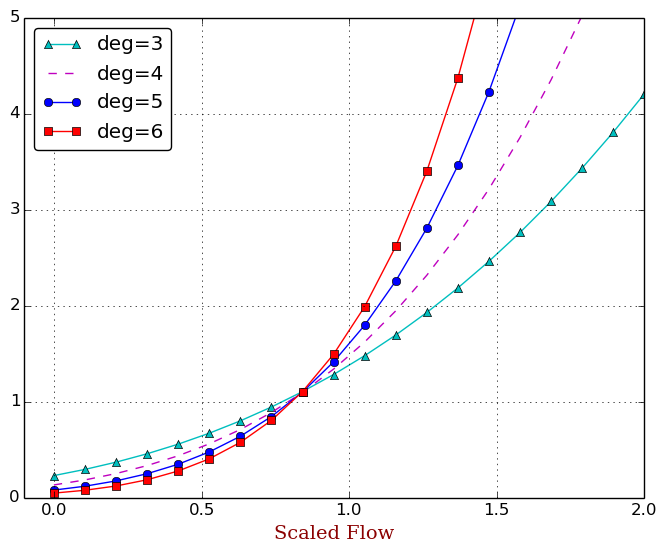

In [20]:
using PyPlot

#true_coeffs = [1, 0, 0, 0, .15]
fcoeffs3 = coeffs_dict[(3, 1., 1e3)]
fcoeffs4 = coeffs_dict[(4, 1., 1e3)]
fcoeffs5 = coeffs_dict[(5, 1., 1e3)]
fcoeffs6 = coeffs_dict[(6, 1., 1e3)]

xs = linspace(0, 2, 20)
#ys_true = map(x->polyEval(true_coeffs, x), xs)
ys3 = map(x->polyEval(fcoeffs3, x), xs)
ys4 = map(x->polyEval(fcoeffs4, x), xs)
ys5 = map(x->polyEval(fcoeffs5, x), xs)
ys6 = map(x->polyEval(fcoeffs6, x), xs)

# ys = map(x->polyEval(fcoeffs, x), xs)

#plot(xs, ys_true, "k", label="True")
plot(xs, ys3, "^-c", label="deg=3")
plot(xs, ys4, "--m", label="deg=4")
plot(xs, ys5, "o-b", label="deg=5")
plot(xs, ys6, "s-r", label="deg=6")
legend(loc="upper left",fancybox="true") 
# plot(xs, ys, "--b")
grid("on")
xlim(-0.1, 2.0);
ylim(0.0, 5.0);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Apr_weekend.pdf")

In [21]:
s = "{\"fcoeffs3\": $(fcoeffs3), \"fcoeffs4\": $(fcoeffs4), \"fcoeffs5\": $(fcoeffs5), \"fcoeffs6\": $(fcoeffs6)}"

outfile = open("../temp_files/fcoeffs_Apr_weekend.json", "w")

JSON.print(outfile, s)

close(outfile)

In [22]:
fcoeffs_Apr_weekend = readall("../temp_files/fcoeffs_Apr_weekend.json")
fcoeffs_Apr_weekend = JSON.parse(JSON.parse(fcoeffs_Apr_weekend))

Dict{String,Any} with 4 entries:
  "fcoeffs5" => {0.07722846399817974,0.3208939731088294,0.5342352010435649,0.44…
  "fcoeffs3" => {0.22830919268246866,0.5613065744381385,0.4608400393298347,0.12…
  "fcoeffs6" => {0.04556643990720988,0.2271967100952837,0.472774076051054,0.525…
  "fcoeffs4" => {0.1308433013211652,0.4349089494680161,0.5430113078603258,0.301…

In [23]:
fcoeffs_Apr_weekend["fcoeffs3"]

4-element Array{Any,1}:
 0.228309
 0.561307
 0.46084 
 0.126329